In [1]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.functions import *
from pyspark.sql.types import *
sc = pyspark.SparkContext()
spark = SparkSession(sc)
sqlContext = SQLContext(sc)

In [2]:
#reading required libraries
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
pd.set_option('display.max_columns', 500)

In [3]:
#reading first file
df1 = spark.read.option("header","true").csv('client_stats_sample_0225part1.csv')
df1.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- location_id: string (nullable = true)
 |-- client_mac: string (nullable = true)
 |-- freq_band: string (nullable = true)
 |-- mac_address: string (nullable = true)
 |-- country: string (nullable = true)
 |-- vendor_name: string (nullable = true)
 |-- rssi_percs_25: string (nullable = true)
 |-- rssi_percs_75: string (nullable = true)
 |-- isp: string (nullable = true)
 |-- total_bytes_tx: string (nullable = true)
 |-- total_bytes_rx: string (nullable = true)
 |-- ts: string (nullable = true)
 |-- txWeightedPhyRate: string (nullable = true)
 |-- rxWeightedPhyRate: string (nullable = true)
 |-- idtype: string (nullable = true)
 |-- is_static: string (nullable = true)
 |-- weighted_prr_tx: string (nullable = true)
 |-- weighted_prr_rx: string (nullable = true)
 |-- num_samples: string (nullable = true)
 |-- is_connected_to_pod: string (nullable = true)
 |-- pod_serial: string (nullable = true)
 |-- control_group: string (nullable = true)
 |-- b

In [4]:
#reading second file
df2 = spark.read.option("header","true").csv('client_stats_sample_0225part2.csv')
df2.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- location_id: string (nullable = true)
 |-- client_mac: string (nullable = true)
 |-- freq_band: string (nullable = true)
 |-- mac_address: string (nullable = true)
 |-- country: string (nullable = true)
 |-- vendor_name: string (nullable = true)
 |-- rssi_percs_25: string (nullable = true)
 |-- rssi_percs_75: string (nullable = true)
 |-- isp: string (nullable = true)
 |-- total_bytes_tx: string (nullable = true)
 |-- total_bytes_rx: string (nullable = true)
 |-- ts: string (nullable = true)
 |-- txWeightedPhyRate: string (nullable = true)
 |-- rxWeightedPhyRate: string (nullable = true)
 |-- idtype: string (nullable = true)
 |-- is_static: string (nullable = true)
 |-- weighted_prr_tx: string (nullable = true)
 |-- weighted_prr_rx: string (nullable = true)
 |-- num_samples: string (nullable = true)
 |-- is_connected_to_pod: string (nullable = true)
 |-- pod_serial: string (nullable = true)
 |-- control_group: string (nullable = true)
 |-- b

In [5]:
#appending both the file to get one final dataframe
df = df1.union(df2)

In [6]:
print(df.count())

700596


In [7]:
#filtering for null values
df = df.filter(col("rssi_percs_25").isNotNull())
df = df.filter(col("txWeightedPhyRate").isNotNull())
df = df.filter(col("rxWeightedPhyRate").isNotNull())



In [8]:
print(df.count())

670257


In [9]:
df.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- location_id: string (nullable = true)
 |-- client_mac: string (nullable = true)
 |-- freq_band: string (nullable = true)
 |-- mac_address: string (nullable = true)
 |-- country: string (nullable = true)
 |-- vendor_name: string (nullable = true)
 |-- rssi_percs_25: string (nullable = true)
 |-- rssi_percs_75: string (nullable = true)
 |-- isp: string (nullable = true)
 |-- total_bytes_tx: string (nullable = true)
 |-- total_bytes_rx: string (nullable = true)
 |-- ts: string (nullable = true)
 |-- txWeightedPhyRate: string (nullable = true)
 |-- rxWeightedPhyRate: string (nullable = true)
 |-- idtype: string (nullable = true)
 |-- is_static: string (nullable = true)
 |-- weighted_prr_tx: string (nullable = true)
 |-- weighted_prr_rx: string (nullable = true)
 |-- num_samples: string (nullable = true)
 |-- is_connected_to_pod: string (nullable = true)
 |-- pod_serial: string (nullable = true)
 |-- control_group: string (nullable = true)
 |-- b

In [10]:
##converting data type for the required columns
df = df.withColumn("rssi_percs_25",col("rssi_percs_25").cast("float"))
df = df.withColumn("txWeightedPhyRate",col("txWeightedPhyRate").cast("float"))
df = df.withColumn("rxWeightedPhyRate",col("rxWeightedPhyRate").cast("float"))
df.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- location_id: string (nullable = true)
 |-- client_mac: string (nullable = true)
 |-- freq_band: string (nullable = true)
 |-- mac_address: string (nullable = true)
 |-- country: string (nullable = true)
 |-- vendor_name: string (nullable = true)
 |-- rssi_percs_25: float (nullable = true)
 |-- rssi_percs_75: string (nullable = true)
 |-- isp: string (nullable = true)
 |-- total_bytes_tx: string (nullable = true)
 |-- total_bytes_rx: string (nullable = true)
 |-- ts: string (nullable = true)
 |-- txWeightedPhyRate: float (nullable = true)
 |-- rxWeightedPhyRate: float (nullable = true)
 |-- idtype: string (nullable = true)
 |-- is_static: string (nullable = true)
 |-- weighted_prr_tx: string (nullable = true)
 |-- weighted_prr_rx: string (nullable = true)
 |-- num_samples: string (nullable = true)
 |-- is_connected_to_pod: string (nullable = true)
 |-- pod_serial: string (nullable = true)
 |-- control_group: string (nullable = true)
 |-- band

### Step 1 -Evaluate Phy Rates at Different RSSI levels

#### 1. Look at the RSSI levels (rssi_percs_25) and look at the spread of Tx and Rx weighted Phy Rate

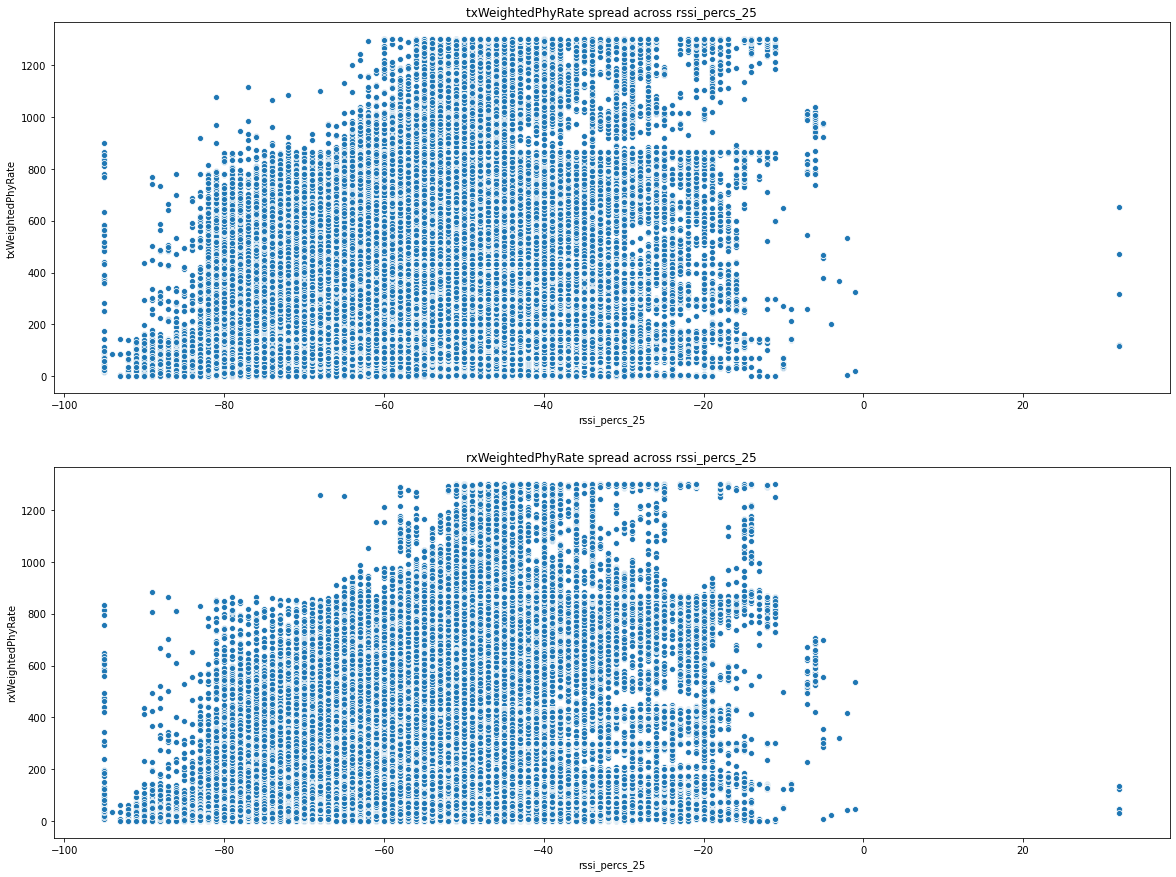

In [11]:
temp_df = df.select("rssi_percs_25","txWeightedPhyRate","rxWeightedPhyRate").toPandas()

plt.figure(figsize=(20,15))
plt.subplot(2,1,1)
sns.scatterplot(x=temp_df['rssi_percs_25'],y=temp_df['txWeightedPhyRate'])
plt.title("txWeightedPhyRate spread across rssi_percs_25")

plt.subplot(2,1,2)
sns.scatterplot(x=temp_df['rssi_percs_25'],y=temp_df['rxWeightedPhyRate'])
plt.title("rxWeightedPhyRate spread across rssi_percs_25")

plt.show()

In [12]:
df.groupBy("rssi_percs_25").agg(min("txWeightedPhyRate").alias("min_txWeightedPhyRate"),max("txWeightedPhyRate").alias("max_txWeightedPhyRate"),min("rxWeightedPhyRate").alias("min_rxWeightedPhyRate"),max("rxWeightedPhyRate").alias("max_rxWeightedPhyRate")).orderBy("rssi_percs_25").show(100,False)

+-------------+---------------------+---------------------+---------------------+---------------------+
|rssi_percs_25|min_txWeightedPhyRate|max_txWeightedPhyRate|min_rxWeightedPhyRate|max_rxWeightedPhyRate|
+-------------+---------------------+---------------------+---------------------+---------------------+
|-95.0        |17.86833             |898.24335            |6.0                  |833.6394             |
|-94.0        |86.4496              |86.4496              |35.67153             |35.67153             |
|-93.0        |0.0                  |142.72241            |1.0                  |62.446777            |
|-92.0        |0.0                  |140.78398            |1.0                  |62.355373            |
|-91.0        |0.0                  |142.89555            |1.0                  |112.3168             |
|-90.0        |0.0                  |438.51257            |1.0                  |436.0077             |
|-89.0        |0.0                  |767.48126            |1.0  

#### 2. Produce a histogram (graph and CSV) for the average Tx and Rx Weighed Phy Rate between -85 and -65 dB in 1 dB steps

In [13]:
#filter data for rssi_percs_25 between -85dB and -65dB
temp_df = df.filter((col("rssi_percs_25")>=-85) & (col("rssi_percs_25")<=-65))
# print(temp_df.agg(min("rssi_percs_25"),max("rssi_percs_25")).show())

In [14]:
#calculating average tx and rx weighted phy rate across rssi_percs_25
temp_df = temp_df.groupby("rssi_percs_25").agg(round(avg("txWeightedPhyRate"),2).alias("avg_txWeightedPhyRate"),round(avg("rxWeightedPhyRate"),2).alias("avg_rxWeightedPhyRate"))
print(temp_df.orderBy("rssi_percs_25").show(100,False))
temp_df.coalesce(1).write.csv('tx_and_rx_average_value_across_rssi_percs_25.csv',mode='overwrite',header=True)


+-------------+---------------------+---------------------+
|rssi_percs_25|avg_txWeightedPhyRate|avg_rxWeightedPhyRate|
+-------------+---------------------+---------------------+
|-85.0        |38.32                |18.49                |
|-84.0        |43.28                |19.94                |
|-83.0        |58.01                |26.48                |
|-82.0        |77.85                |33.81                |
|-81.0        |98.22                |42.02                |
|-80.0        |92.05                |45.74                |
|-79.0        |99.06                |52.27                |
|-78.0        |103.78               |61.62                |
|-77.0        |108.89               |68.47                |
|-76.0        |117.44               |73.83                |
|-75.0        |124.28               |81.56                |
|-74.0        |128.11               |89.09                |
|-73.0        |133.94               |96.23                |
|-72.0        |135.43               |96.

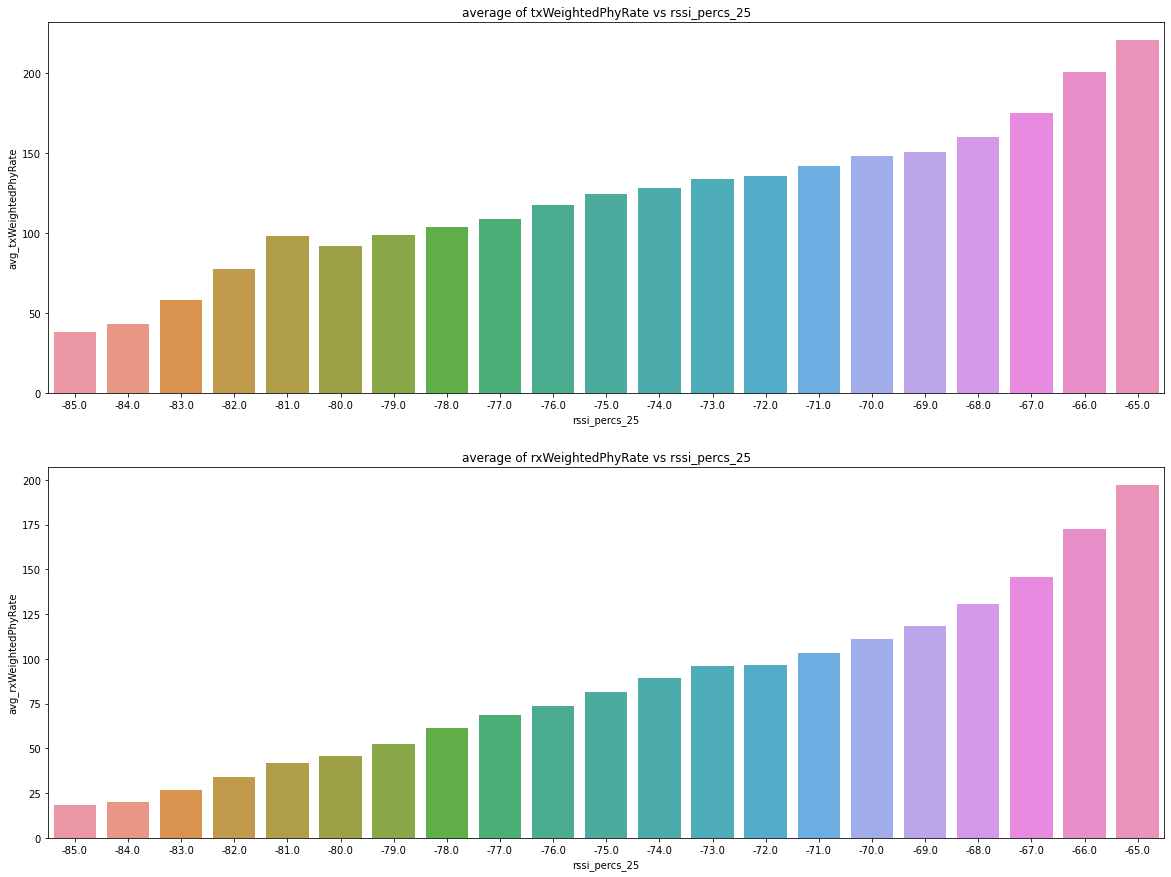

In [15]:
temp_df = temp_df.toPandas()

#bar plot to show the histogram
plt.figure(figsize=(20,15))

plt.subplot(2,1,1)
sns.barplot(x=temp_df['rssi_percs_25'],y=temp_df['avg_txWeightedPhyRate'])
plt.title("average of txWeightedPhyRate vs rssi_percs_25")

plt.subplot(2,1,2)
sns.barplot(x=temp_df['rssi_percs_25'],y=temp_df['avg_rxWeightedPhyRate'])
plt.title("average of rxWeightedPhyRate vs rssi_percs_25")

plt.show()

### Step 2: Evaluate RSSI threshold

#### 1. % of devices connected to 2.4 GHz and 5 GHz¶

In [16]:
temp_df = df.groupBy("freq_band").agg(countDistinct("client_mac").alias("total_unique_connected_devices"))
total_unique_devices = temp_df.agg(sum("total_unique_connected_devices")).rdd.flatMap(lambda x:x).collect()[0]
temp_df = temp_df.withColumn("%age_connected_devices",round((col("total_unique_connected_devices")/total_unique_devices)*100,2))
temp_df.show()

+---------+------------------------------+----------------------+
|freq_band|total_unique_connected_devices|%age_connected_devices|
+---------+------------------------------+----------------------+
|     2.4G|                          7468|                 51.33|
|       5G|                          7080|                 48.67|
+---------+------------------------------+----------------------+



Finding : 51% of total devices are connected to 2.4G where as 49% of devices are connected to 5G

#### 2. Evaluating new freq basis business rule

In [17]:
from pyspark.sql.types import *
def get_new_freq_band(freq_band,rssi_percs_25):
    if ((freq_band=='2.4G') & (rssi_percs_25 >= -60)):
        return '5G'
    elif ((freq_band=='5G') & (rssi_percs_25 <= -75)):
        return '2.4G'
    elif ((freq_band=='5G') & (rssi_percs_25 > -75)):
        return '5G'
    elif ((freq_band=='2.4G') & (rssi_percs_25 < -60)):
        return '2.4G'
generate_new_freq_band_udf = udf(get_new_freq_band, StringType())

df = df.withColumn('new_freq_band',generate_new_freq_band_udf(col("freq_band"),col("rssi_percs_25")))


In [18]:
temp_df = df.groupBy("new_freq_band").agg(countDistinct("client_mac").alias("total_unique_connected_devices"))
total_unique_devices = temp_df.agg(sum("total_unique_connected_devices")).rdd.flatMap(lambda x:x).collect()[0]
temp_df = temp_df.withColumn("%age_connected_devices",round((col("total_unique_connected_devices")/total_unique_devices)*100,2))
temp_df.show()

+-------------+------------------------------+----------------------+
|new_freq_band|total_unique_connected_devices|%age_connected_devices|
+-------------+------------------------------+----------------------+
|         2.4G|                          6243|                  40.4|
|           5G|                          9211|                  59.6|
+-------------+------------------------------+----------------------+



Findings : Post making the transition to new_freq_band, 40% of total devices are connected to 2.4G whereas for 5G band %age connected device increased to 60%

Yes, Post transition there will be more devices connected to 5G